# Understanding the execution flow from `LightningQubit`

In [1]:
from typing import Iterable, Union
import quimb.tensor as qtn
import pennylane as qml
from pennylane.wires import Wires
import numpy as np

/home/pietropaolo.frisoni/anaconda3/envs/PennyLane/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
_backends = frozenset({"quimb"})

In [3]:
type(_backends)

frozenset

## Approach 1: choosing a tape

In [4]:
theta = 0.1
phi = 0.2

O1 = qml.Identity(wires=[0])
O2 = qml.PauliZ(wires=[1])

ops = [
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[0, 1]),
]

meas = [qml.expval(O1), qml.expval(O2)]

tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [5]:
tape.operations

[X(0), RX(0.1, wires=[0]), RX(0.2, wires=[1]), CNOT(wires=[0, 1])]

In [6]:
tape.observables

[I(0), Z(1)]

In [7]:
tape.measurements

[expval(I(0)), expval(Z(1))]

## Approach 2: choosing a circuit

In [8]:
from functools import partial
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane.tape import QuantumScript, QuantumTape

dev = qml.device("lightning.qubit", wires=3)


@qml.qnode(dev)
def circuit(angles):
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RX(angles[0], 0)
    qml.CNOT(wires=[1, 0])
    qml.CNOT(wires=[2, 1])
    qml.RX(angles[2], wires=0)
    qml.RZ(angles[1], wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RZ(-angles[1], wires=2)
    qml.CNOT(wires=[1, 0])
    qml.Hadamard(wires=1)
    qml.CY(wires=[1, 2])
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(wires=0))


angles = [0.1, 0.3, 0.5]
# qnode = qml.QNode(circuit, dev)
# qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
# plt.show()

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=None



In [9]:
circuit(angles=angles)

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=<QuantumScript: wires=[1, 2, 0], params=0>

Frisus log: execute_and_compute_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=True, use_device_gradient=True, use_device_jacobian_product=False, gradient_method='adjoint', gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x78A7B0A85AC0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface='autograd', derivative_order=1)
circuits=(<QuantumScript: wires=[1, 2, 0], params=0>,)



0.8253356149096777

In [10]:
dev.preprocess()

(TransformProgram(validate_measurements, validate_observables, validate_device_wires, mid_circuit_measurements, decompose, broadcast_expand),
 ExecutionConfig(grad_on_execution=True, use_device_gradient=False, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x78A7B0A85AC0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface=None, derivative_order=1))

In [11]:
dev.execute(circuits=tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1], params=2>,)



(1.0, -0.975170327201816)

In [12]:
qml.expval

<function pennylane.measurements.expval.expval(op: Union[pennylane.operation.Operator, pennylane.measurements.mid_measure.MeasurementValue])>

## Learning from `LightningQubit` using Python API

In [13]:
from pennylane_lightning.lightning_qubit import LightningQubit

In [14]:
obj = LightningQubit(wires=[0, 1, 2])

In [15]:
obj.tracker

In [16]:
obj._statevector

In [17]:
obj._statevector.state_vector

In [18]:
obj._statevector.state

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [19]:
program, config = obj.preprocess()

In [20]:
program[0]

<validate_measurements([], {'name': 'lightning.qubit'})>

In [21]:
res = obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1], params=2>,)



In [22]:
obj._statevector.state

array([ 0.        -0.04972948j,  0.        +0.j        ,
       -0.00498959+0.j        ,  0.        +0.j        ,
        0.        -0.09970865j,  0.        +0.j        ,
        0.99376067+0.j        ,  0.        +0.j        ])

In [23]:
obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1], params=2>,)



(1.0, -0.975170327201816)

In [24]:
qml.var

<function pennylane.measurements.var.var(op: Union[pennylane.operation.Operator, pennylane.measurements.mid_measure.MeasurementValue]) -> 'VarianceMP'>

## Testing `LightningTensor` 

In [25]:
wires = Wires([0, 1, 2])
backend = "quimb"
method = "mps"
c_dtype = np.complex128
max_bond_dim = 50

In [26]:
from pennylane_lightning.lightning_tensor import LightningTensor

In [27]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
)

In [28]:
obj._interface.state

MatrixProductState(tensors=3, indices=5, L=3, max_bond=2)

In [29]:
obj._interface.state_to_array()

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

In [30]:
print(obj.wires)

<Wires = [0, 1, 2]>


In [31]:
program, config = obj.preprocess()

In [32]:
program[0]

<validate_measurements([], {'name': 'lightning.tensor'})>

In [33]:
config.device_options

{'apply_reverse_lightcone': None,
 'backend': 'quimb',
 'c_dtype': numpy.complex128,
 'cutoff': 1e-16,
 'method': 'mps',
 'max_bond_dim': 50,
 'measure_algorithm': None,
 'return_tn': None,
 'rehearse': None}

In [34]:
obj._interface._verbosity = True

obj.execute(circuits=tape)

LOG: execute called with:
circuits=(<QuantumScript: wires=[0, 1], params=2>,)

LOG: resetting the MPS

LOG: applying X(0) to the circuit...
LOG: MPS after operation:
MatrixProductState([
    Tensor(shape=(1, 2), inds=('_faf3a9AAAAC', 'k0'), tags=oset(['0', '1', '2', 'I0', 'PSI0', 'GATE_0'])),
    Tensor(shape=(1, 1, 2), inds=('_faf3a9AAAAC', '_faf3a9AAAAD', 'k1'), tags=oset(['0', '1', '2', 'I1', 'PSI0'])),
    Tensor(shape=(1, 2), inds=('_faf3a9AAAAD', 'k2'), tags=oset(['0', '1', '2', 'I2', 'PSI0'])),
], tensors=3, indices=5, L=3, max_bond=2)

LOG: applying RX(0.1, wires=[0]) to the circuit...
LOG: MPS after operation:
MatrixProductState([
    Tensor(shape=(1, 2), inds=('_faf3a9AAAAC', 'k0'), tags=oset(['0', '1', '2', 'I0', 'PSI0', 'GATE_0', 'GATE_1'])),
    Tensor(shape=(1, 1, 2), inds=('_faf3a9AAAAC', '_faf3a9AAAAD', 'k1'), tags=oset(['0', '1', '2', 'I1', 'PSI0'])),
    Tensor(shape=(1, 2), inds=('_faf3a9AAAAD', 'k2'), tags=oset(['0', '1', '2', 'I2', 'PSI0'])),
], tensors=3, indices=

(1.0, -0.9751703272018161)

In [35]:
# obj._interface.state_to_array()

In [36]:
tape.shots.total_shots

In [37]:
tape.measurements[0].obs.name

'Identity'

In [38]:
isinstance(tape, QuantumScript)

True

In [39]:
tape._ops

[X(0), RX(0.1, wires=[0]), RX(0.2, wires=[1]), CNOT(wires=[0, 1])]

In [40]:
tape.circuit

[X(0),
 RX(0.1, wires=[0]),
 RX(0.2, wires=[1]),
 CNOT(wires=[0, 1]),
 expval(I(0)),
 expval(Z(1))]

In [41]:
print(tape)

<QuantumScript: wires=[0, 1], params=2>


In [42]:
tape.operations

[X(0), RX(0.1, wires=[0]), RX(0.2, wires=[1]), CNOT(wires=[0, 1])]

In [43]:
type(tape.measurements[0].obs)

pennylane.ops.identity.Identity

In [44]:
qc = qtn.CircuitMPS(N=len(wires), tags=[str(l) for l in wires.labels])
qc.psi

MatrixProductState(tensors=3, indices=5, L=3, max_bond=2)

In [45]:
qc

<Circuit(n=3, num_gates=0, gate_opts={'contract': 'swap+split', 'propagate_tags': 'register'})>

In [46]:
op = tape.operations[0]

In [47]:
op

X(0)

In [48]:
op.has_diagonalizing_gates

True

In [49]:
op.matrix()

array([[0, 1],
       [1, 0]])

In [50]:
op.wires

<Wires = [0]>

In [51]:
qc.psi.gate_(op.matrix(), tuple(op.wires), contract="swap+split")

MatrixProductState(tensors=3, indices=5, L=3, max_bond=2)

In [52]:
qc.psi

MatrixProductState(tensors=3, indices=5, L=3, max_bond=2)

In [53]:
qc.apply_gate(
    op.matrix(), *op.wires, contract="swap+split", max_bond=0, parametrize=None
)

In [54]:
qc.to_dense()

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

In [55]:
isinstance(tape, QuantumScript)

True

In [56]:
fs_opts = {
    "simplify_sequence": "ADCRS",
    "simplify_atol": 0.0,
}

qc.local_expectation(op.matrix(), tuple(op.wires), **fs_opts)

0j

In [57]:
obs = tape.measurements

In [58]:
obs[0]

expval(I(0))

In [59]:
obs[0].obs

I(0)

In [60]:
qtn.Circuit(N=len(wires), tags=[str(l) for l in wires.labels]).to_dense()

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

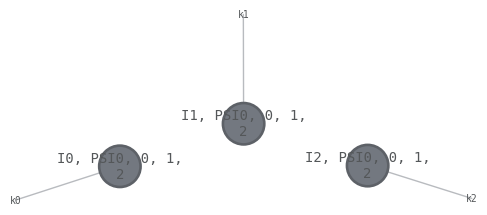

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


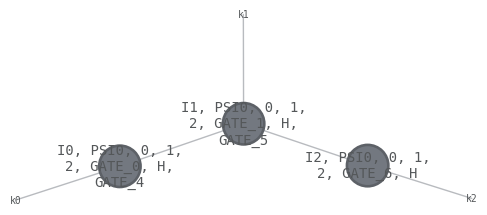

[[ 7.07106781e-01+0.j]
 [-5.26737602e-17+0.j]
 [ 7.00186921e-17+0.j]
 [ 6.00801752e-17+0.j]
 [ 6.00801752e-17+0.j]
 [ 7.00186921e-17+0.j]
 [-5.26737602e-17+0.j]
 [ 7.07106781e-01+0.j]]


In [61]:
qc = qtn.CircuitMPS(N=len(wires), tags=[str(l) for l in wires.labels])

gates = [
    ("H", 0),
    ("H", 1),
    ("CNOT", 1, 2),
    ("CNOT", 0, 2),
    ("H", 0),
    ("H", 1),
    ("H", 2),
]

qc.psi.draw()

print(qc.psi.to_dense())

qc.apply_gates(gates)

qc.psi.draw()

print(qc.psi.to_dense())

In [62]:
qc.psi.max_bond()

2

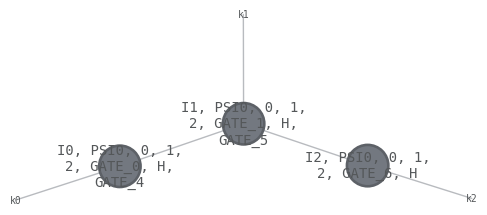

In [63]:
qc.psi.draw()

In [64]:
qc = qtn.CircuitMPS(N=len(wires), tags=[str(l) for l in wires.labels])

In [65]:
qc.to_dense_tn()

MatrixProductState(tensors=3, indices=3, L=3, max_bond=2)

In [66]:
qtn.MPS_computational_state(
    "0" * max(1, len(wires)),
)

MatrixProductState(tensors=3, indices=5, L=3, max_bond=2)

In [67]:
p = qtn.MPS_rand_state(L=20, bond_dim=50)
print(f"Site tags: '{p.site_tag_id}', site inds: '{p.site_ind_id}'")

Site tags: 'I{}', site inds: 'k{}'


In [68]:
p.max_bond()

50

In [69]:
import math

obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
coeff = [1.0]
expected = math.cos(0.4) * math.cos(-0.2)

tape = qml.tape.QuantumScript(
    [qml.RX(0.4, wires=[0]), qml.RY(-0.2, wires=[1])],
    [qml.var(qml.Hamiltonian(coeff, obs))],
)

In [70]:
tape.measurements

[var(1.0 * (Z(0) @ Z(1)))]

In [71]:
dev = qml.device("default.qubit")
dev.execute(tape)

0.18513073060254281

In [72]:
num_wires = 2
wires = Wires(range(num_wires))
dev = LightningTensor(wires=wires, backend="quimb", method="mps", c_dtype=np.complex64)
result = dev.execute(circuits=tape)
result

LOG: execute called with:
circuits=(<QuantumScript: wires=[0, 1], params=3>,)

LOG: resetting the MPS

LOG: applying RX(0.4, wires=[0]) to the circuit...
LOG: MPS after operation:
MatrixProductState([
    Tensor(shape=(1, 2), inds=('_faf3a9AAABR', 'k0'), tags=oset(['0', '1', 'I0', 'PSI0', 'GATE_0'])),
    Tensor(shape=(1, 2), inds=('_faf3a9AAABR', 'k1'), tags=oset(['0', '1', 'I1', 'PSI0'])),
], tensors=2, indices=3, L=2, max_bond=2)

LOG: applying RY(-0.2, wires=[1]) to the circuit...
LOG: MPS after operation:
MatrixProductState([
    Tensor(shape=(1, 2), inds=('_faf3a9AAABR', 'k0'), tags=oset(['0', '1', 'I0', 'PSI0', 'GATE_0'])),
    Tensor(shape=(1, 2), inds=('_faf3a9AAABR', 'k1'), tags=oset(['0', '1', 'I1', 'PSI0', 'GATE_1'])),
], tensors=2, indices=3, L=2, max_bond=2)

LOG: measuring the var of obs 1.0 * (Z(0) @ Z(1))...

LOG: execute results=(0.18513077,)

LOG: MPS after execution:
MatrixProductState([
    Tensor(shape=(2,), inds=('k0',), tags=oset(['0', '1', 'I0', 'PSI0', 'GATE_0

0.18513077